# Composite Pulses with IonQ to Correct for Errors and using Composite Pulses for Quantum Signal Processing

I-Tung Chen and Tommy Nguyen

### References
[1] https://arxiv.org/pdf/quant-ph/0404064.pdf

[2] https://arxiv.org/abs/2105.02859

## Introduction 
The IonQ trapped-ion quantum computer is among the few noisy intermediate-scale quantum (NISQ) computers available via cloud services to the general public.
The ability to test algorithms on NISQ devices is an important tool for the advancement of quantum information science.
Beyond the target application space, there is also much opportunity for the study of inherent noise of NISQ devices which serves as a basic plaform for the development of algorithmic-level approaches towards improving the robustness of quantum information devices overall. Not only this, but in our own research labs, we use RF pulses to intialize our states via spin echo or optically detected magnetic resonance (ODMR) experiments with NV centers and quantum dots, so undergoing this research study at this hackathon is a cool way to try and see what the future of our research might hold in terms of actual quantum hardware.

Our goal for this hackathon is an experimental research study on composite pulses to:
1. Look at the noise from IonQ's native gates and see if they can be corrected for with a BB1 Composite Pulse Sequence 
2. Implement and test different composite pulse sequences (BB and NB and maybe PB) for applications in quantum signal processing (QSP) and see what advantages they might have

These goals will be looked at and compared between a cloud based simulator, IonQ's simulators and IonQ's QPU on actual quantum hardware!

## Background: Composite Pulses
The usefulness of a composite pulse - a sequence of pulses - is that it can correct for systematic errors than just using a single pulse due to strategic cancellation. If you've heard of a spin echo experiment in quantum optics, the idea is essentially the same, thereofore, this technique works very well for RF inhomogenieties, frequency offsets, and imperfect pulse lengths.  

## A directly implementable composite pulse: BB1$_\pi$

A pulse sequence that we can directly implement and easily check is the BB1$_\pi$ pulse sequence given by [1]

\begin{equation}
    BB1_{\theta = \pi} = R_\phi(\pi) R_{3\phi} (2\pi) R_{\phi} (\pi) R_x (\theta = \pi)
\end{equation}

where $\cos\phi = - \theta / 4 \pi$, which is a composite pulse sequence that implements an arbitrary $R_x(\theta = \pi)$ with sixth-order supression of pulse-length errors.
This is a good opportunity to verify the usefulness of composite pulses


In [2]:
## Imports
from qiskit_ionq import IonQProvider, GPIGate, GPI2Gate
from qiskit.providers.jobstatus import JobStatus


import numpy as np
import matplotlib.pyplot as plt

In [3]:
## Getting backends
from azure.quantum.qiskit import AzureQuantumProvider

#paste your Resource id here
resource_id = "/subscriptions/d00d1ca0-9b6c-4343-bada-4ceddc049215/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/NQNHackathon"

#Import your azure quantum provider resource_id
provider = AzureQuantumProvider (
    resource_id = resource_id,
    location = "westus"
)

from qiskit.providers.aer import QasmSimulator
qasm_backend = QasmSimulator()

sim_backend_qis = provider.get_backend('ionq.simulator', gateset='qis')
sim_backend_nat = provider.get_backend('ionq.simulator', gateset='native')

qpu_backend_qis = provider.get_backend('ionq.qpu.aria-1', gateset='qis')
qpu_backend_nat = provider.get_backend('ionq.qpu.aria-1', gateset='native')

In [4]:
from qiskit.providers.aer import QasmSimulator
qasm_backend = QasmSimulator()

In [5]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity

Let us first consider an implementation using an ideal machine via the QASM simultator and simulating the error directly.

Suppose we have a pulse-length error that takes $R_x(\theta) \to R_x(\theta(1+\epsilon))$.
As a result the $R_x(\pi)$ will over rotate an arbitrary input; some amount of the resulting output will thus measure as 0 rather than 1 as expected:

In [61]:
# Define the angles
theta = np.pi
phi = np.arccos(- theta / (4 * np.pi))

# Define the error
epsilon = 0.1
ttheta = np.pi * (1 + epsilon)

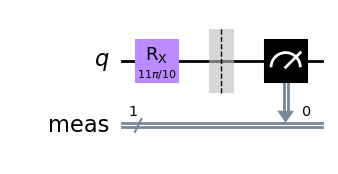

In [62]:
circ_rx = QuantumCircuit(1)

# Using a circuit with a pulse-length error
circ_rx.rx(theta=ttheta, qubit=0)

circ_rx.measure_all()

circ_rx.draw('mpl')

Now running the job on the QASM simulator backend we see that there is some number of measurements of 0 which is incorrect from our epsilon error, despite the desired implementation being a $\pi$ pulse which should take |0> -> |1>.

In [63]:
job = qasm_backend.run(circ_rx, shots=10000) 

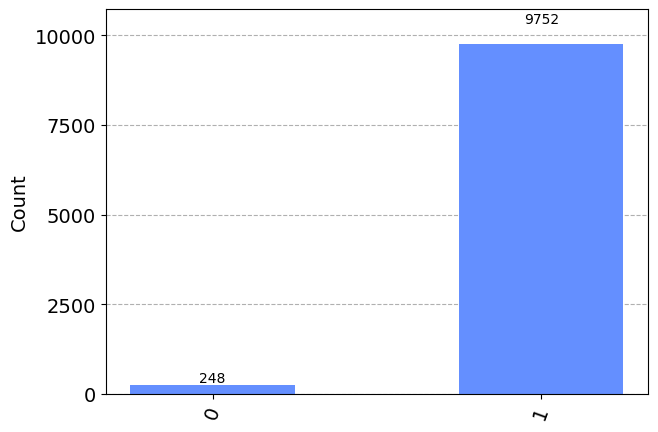

In [64]:
plot_histogram(job.result().get_counts())

Now let's do this with the BB1 pulse sequence and see if the composite pulse sequence can account for the error

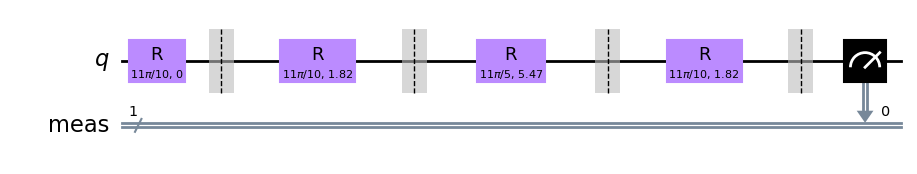

In [65]:
circ_BB1 = QuantumCircuit(1)

# Note that the error occurs in all parts of the pulse
circ_BB1.r(theta=ttheta, phi=0, qubit=0)
circ_BB1.barrier()
circ_BB1.r(theta=np.pi * (1 + epsilon), phi=phi, qubit=0)
circ_BB1.barrier()
circ_BB1.r(theta=2*np.pi * (1 + epsilon), phi=3 * phi, qubit=0)
circ_BB1.barrier()
circ_BB1.r(theta=np.pi * (1 + epsilon), phi=phi, qubit=0)
circ_BB1.measure_all()

circ_BB1.draw('mpl')

Running the job for the BB1 pulse sequence, we see that the errors are significantly surpressed and accounted for!

In [66]:
job = qasm_backend.run(circ_BB1, shots=10000) 

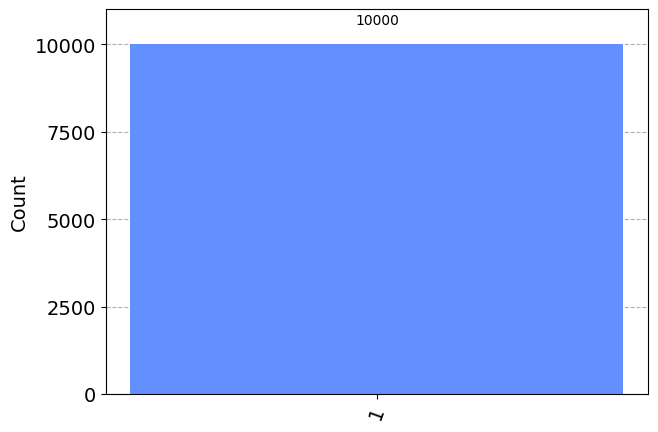

In [67]:
plot_histogram(job.result().get_counts())

So the composite pulse sequence works!

Now let's try to do the same thing but instead of introducing the error ourselves with $\epsilon$. Let's do the simulation with IonQ's native gates and see if there are errors in IonQ's native gates, and if we can correct for them with our composite pulse sequence.

## Background: Native gates for IonQ

The IonQ system is equipped with two user-accessible native gates for single-qubit operations: the GPi and GPi2 gates.
Both of these gates are physically implemented as $\pi$ and $\pi/2$ Rabi oscillations of individual qubits within the system.
As such, these gates are prone to errors which arise from both amplitude and pulse length errors which result in over-/under-rotations of the qubit on the Bloch sphere.
There is also the potential for phase errors but these are implemented internal to the control system and thus are expected to have a higher degree of fidelity than the physically implemented pulse-type errors so we can ignore them.
Our goal for this section is to probe both the pulse and phase errors.

A general rotation by angle $\theta$ around axis given by $\hat n$ is given by the matrix exponential

\begin{equation}
    R_{\hat n} (\theta) = \exp\Bigg( - \frac{i\theta \hat n \cdot \mathbf{\sigma} }{2} \Bigg)
\end{equation}

which can also be expressed in the form

\begin{equation}
    R_{\hat n} (\theta) = \cos\frac{\theta}{2} I - i \sin\frac{\theta}{2} (n_x X + n_y Y + n_z Z).
\end{equation}

Restricting ourselves to rotations about axes in the $xy$-plane given by azimuthal angle $\varphi$ then we can write the matrix form

\begin{equation}
    R_{\varphi} (\theta) = 
    \begin{bmatrix}
        \cos\frac{\theta}{2} & -i e^{-i\varphi} \sin\frac{\theta}{2} \\
        -i e^{i\varphi} \sin\frac{\theta}{2} & \cos\frac{\theta}{2}
    \end{bmatrix}.
\end{equation}

From here we are able to explicitly relate the single-qubit native gates of the IonQ system to rotations on the Bloch sphere.

The GPi gate is given by the matrix

\begin{equation}
    GPI(\phi) = 
    \begin{bmatrix}
        0 & e^{-i\phi} \\ e^{i\phi} & 0
    \end{bmatrix}
\end{equation}

As the documentation (and name) suggests, the GPi gate implements a $\pi$ rotation of the qubit about an arbitrary azimuthal axis.
One observes that the rotation axis is indeed given by the azimuthal angle $\phi$ but we do not include the effect of an overal global phase of $-i$ which would directly equate it to the $R_\phi(\pi)$ gate.
Thus we make the equivalence

\begin{equation}
    GPI(\phi) = i R_\phi(\pi),
\end{equation}

which establishes the first single-qubit native gate as a rotation.

Similarly the GPi2 gate

\begin{equation}
    GPI_2(\phi) = \frac{1}{\sqrt{2}}
    \begin{bmatrix}
        1 & -ie^{-i\phi} \\ -ie^{i\phi} & 1
    \end{bmatrix} 
\end{equation}

is straightforwardly seen to be a $\pi/2$ rotation about the axis $\phi$.
We can similarly establish

\begin{equation}
    GPI_2(\phi) = R_\phi(\pi/2).
\end{equation}

### To do general $R_x(\theta) $ Rotations

A general $R_x(\theta)$ rotation in the native gateset by the unitary

\begin{equation}
    R_x(\theta) = GPI_2(\phi=\pi/2) GZ(\theta) GPI_2^\dagger(\phi=\pi/2) = GPI_2(\phi=\pi/2) GZ(\theta) GPI_2(\phi=-\pi/2)
\end{equation}

Unfortunately, IonQ does not allow for direct usage of the $GZ(\theta) = R_z(\theta)$ gate in the circuit compilation and so we have to manually append the phase offset to all future gates, i.e.


\begin{equation}
    R_x(\theta) \equiv GPI_2(\phi=\pi/2 + \theta) GPI_2(\phi=-\pi/2).
\end{equation}

Note that this requires that **all** subsequent gates are phase shifted by $\theta$. This will be handy later when we try to implement composite pulses for QSP purposes.

### Implementation with native gates on the IonQ system

First the $R_x(\pi)$ control experiment which is directly implemented by a GPi pulse:

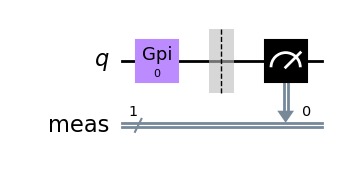

In [8]:
circ_rx = QuantumCircuit(1)

# Implement the Rx(pi) via a single GPI with argument phi = 0
circ_rx.append(GPIGate(0),[0]) 
circ_rx.measure_all()

circ_rx.draw('mpl')

In [9]:
job1 = sim_backend_nat.run(circ_rx, shots=1000)

........

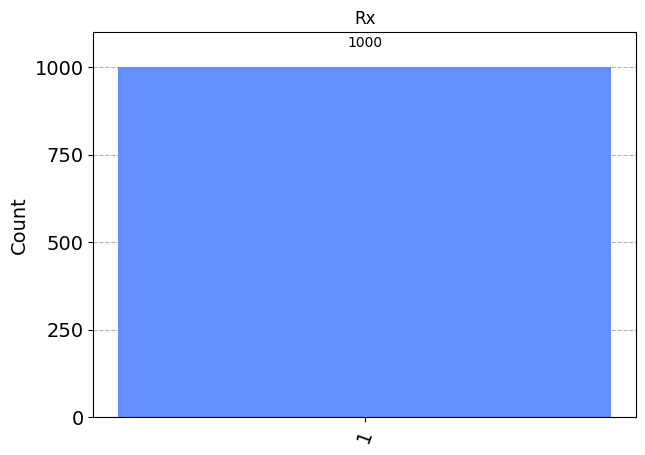

In [10]:
# Direct Rx
plot_histogram(job1.result().get_counts(), title = "Rx")

The BB1 pulse sequence can similarly be implemented using GPi pulses and choosing the argument $\phi$ correctly:

In [11]:
# Define the angles
theta = np.pi
phi = np.arccos(- theta / (4 * np.pi))

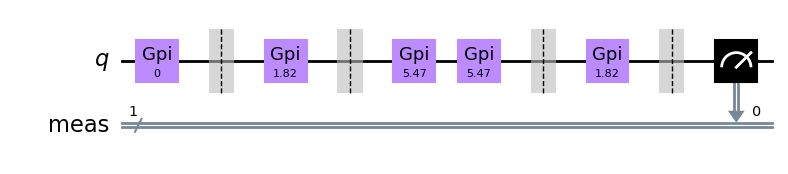

In [12]:
circ_BB1 = QuantumCircuit(1)

circ_BB1.append(GPIGate(0),[0]) 
circ_BB1.barrier()
circ_BB1.append(GPIGate(phi),[0]) 
circ_BB1.barrier()

# The 2*pi pulse around 3*phi is implemented via two GPi Gates
circ_BB1.append(GPIGate(3 * phi),[0]) 
circ_BB1.append(GPIGate(3 * phi),[0]) 
circ_BB1.barrier()
circ_BB1.append(GPIGate(phi),[0]) 


circ_BB1.measure_all()

circ_BB1.draw('mpl')

Running the jobs on the IonQ simulator backend using the native gateset:

In [13]:
job2 = sim_backend_nat.run(circ_BB1, shots=1000)

........

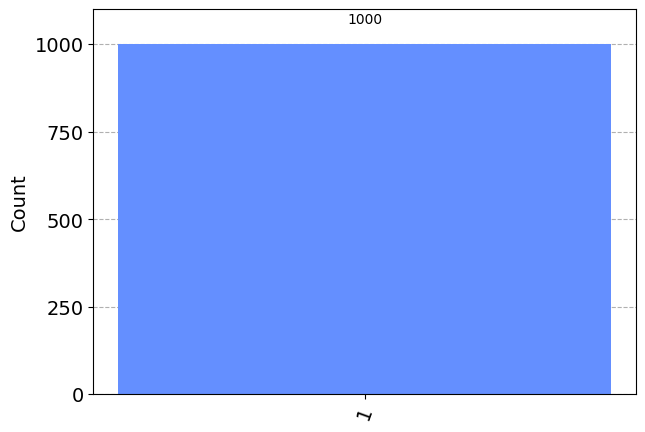

In [14]:
# BB1 implementation
plot_histogram(job2.result().get_counts())

This is odd, the simulator does not seem to include the noise one would expect that is inherent to the native IonQ GPI gates. 
We are not sure if this is because the simulator assumes better results than expected or if there is some other resason that leads to this.

### Running on IonQ QPU

In [15]:
job1 = qpu_backend_nat.run(circ_rx, shots=1000)
job2 = qpu_backend_nat.run(circ_BB1, shots=1000)

In [16]:
print('job1 (R_x) ID:', job1.job_id())
print('job2 (BB1) ID:', job2.job_id())

job1 (R_x) ID: b327918e-9a99-11ed-81ee-acde48001122
job2 (BB1) ID: b397486c-9a99-11ed-81ee-acde48001122


In [18]:
job1 = qpu_backend_nat.retrieve_job('b327918e-9a99-11ed-81ee-acde48001122')
job2 = qpu_backend_nat.retrieve_job('b397486c-9a99-11ed-81ee-acde48001122')

print('RX ; ID:', 'b327918e-9a99-11ed-81ee-acde48001122', 'is done?',job1.done())
print('BB1; ID:', 'b397486c-9a99-11ed-81ee-acde48001122', 'is done?',job2.done())

RX ; ID: b327918e-9a99-11ed-81ee-acde48001122 is done? False
BB1; ID: b397486c-9a99-11ed-81ee-acde48001122 is done? False


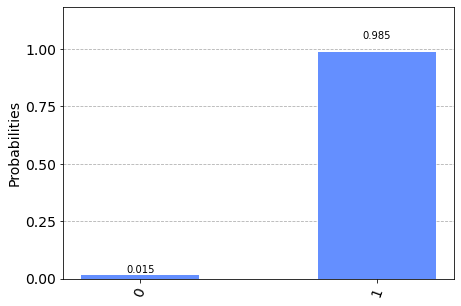

In [5]:
# Direct Rx
plot_histogram(job1.result().get_counts())

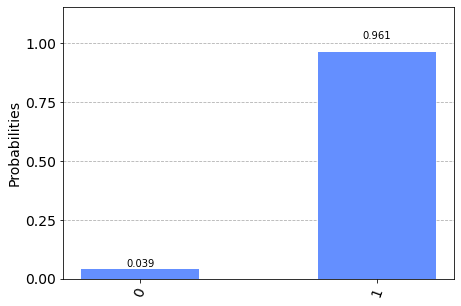

In [6]:
# BB1 implementation
plot_histogram(job2.result().get_counts())

Unfortunately, it seems as though the performance of the BB1 circuit is at best comparable to the direct implementation, if not slightly worse.
This is perhaps not too surprising since the BB1 sequence is intended to correct for only the specific type of errors corresponding to _consistent_ pulse-length errors.
If the errors here are a result of SPAM-type noise or other stochastic sources, then it is likely that these sources of noise are masking any corrections to small pulse length errors that BB1 achieves.
Recall that even large errors of about 10% over-rotation in the QASM simulations produced noise to a similar degree (by measure of spurious 0 counts).
It would be expected that the IonQ system has pulse-length errors that are at least smaller than this error rate, so the noise signal is expected to be quite small.

## Composite Pulses in Quantum Signal Processing (QSP)

Although BB1 may not serve as a means of counteracting error in the currently available NISQ systems, there is potential for composite pulses, such as BB1, to have significance in QSP, such as increasing the parameter sensitivity as discussed in [2]. 
Such modification of the transition probability bears some significance to generalizations of quantum algorithms. Let's look at this! 


### Theory
Following the discussion in [2], the BB1 sequence (and indeed general QSP sequences) can be represented as a sequence of operations:

\begin{equation}
    U = e^{i\phi_0 Z} \prod_{k=1}^{d} W(a) e^{i \phi_k Z} =R_z(\phi_0) U_{\phi_1}U_{\phi_2}U_{\phi_3} ...U_{\phi_N} =  R_z(\phi_0)\cdot R_x(\theta)R_z(\phi_1)\cdot R_x(\theta)R_z(\phi_2)... R_x(\theta)R_z(\phi_N),
\end{equation}

i.e. a series of interleaved $R_z$ rotations by a vector of angles $\phi$ and a single operator $W(a)$.
To not stray too far from what has already been discussed, we note that the rotation operator $W(a)$ is can be taken to be an $x$-rotation operator by angle $\theta = -2\cos^{-1}a$.
In other words we can let $W(a) = R_x(-2\cos^{-1}a)$ --- since we want to parameterize in terms of $\theta$ anyway it is fine to ignore the $a$ variable for this work. 

### Implementing general BB1$_\theta$ for QSP
So in the above section, we did everything to implement a $R_X(\theta = \pi)$ pulse. Now let's do it for general $\theta$ and compare it to $R_X(\theta)$. As given by [2] , the set of phases $\phi = (\pi/2, -\eta, 2\eta, 0, -2\eta, \eta)$ with $\eta = \cos^{-1}(-1/4) / 2$ gives the BB1 sequence. Let's try it out and see what happens

### QASM simulation

An important note: the QSP description uses a series of $Z$ operator exponentials.
This corresponds to a $Z$ rotation, however the precise angle of the rotation is not $\phi$ but actually $-2\phi$ due to the definition of the rotation operators. This change is important in following code.

In [23]:
def qsp_bb1(theta):
    
    circ = QuantumCircuit(1)
    
    eta = np.arccos(-1/4) / 2
    phi = [np.pi/2, -eta, 2*eta, 0, -2*eta, eta]

    for i in range(0, 5):
        circ.rz(phi=-2*phi[5-i], qubit=0)
        circ.rx(theta=theta, qubit=0)
        circ.barrier()

    circ.rz(phi=-2*phi[0], qubit=0)
    
    circ.measure_all()

    return circ

def Rx_circ(theta):
    circ = QuantumCircuit(1)

    # R_x(theta)
    circ.rx(theta, qubit=0)
    
    # Measure the qubit
    circ.measure_all()
    
    return circ

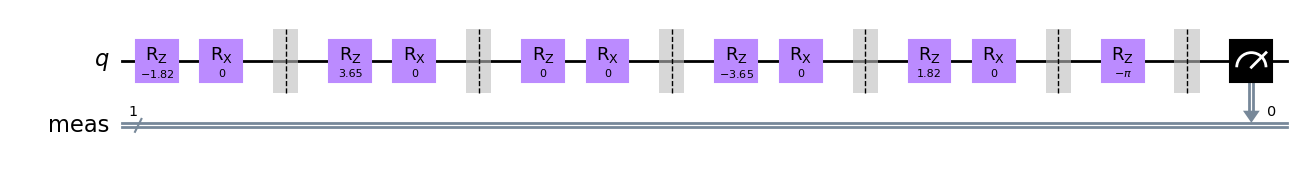

In [24]:
qsp_bb1(0).draw('mpl')

In [25]:
thetas = np.linspace(-np.pi, np.pi, 21)

In [26]:
qsp_circuits = []
rx_circuits = []

for theta in thetas:
    qsp_circuits.append( qsp_bb1(theta) )
    rx_circuits.append( Rx_circ(theta) )

In [28]:
# to tally counts
def calc_p0(counts):
    
    try:
        counts['1']
    except:
        counts['1'] = 0
        
    try:
        counts['0']
    except:
        counts['0'] = 0
    
    total = counts['0'] + counts['1']
    return counts['0'] / total

In [29]:
qsp_p0s = []
for circuit in qsp_circuits:
    job = qasm_backend.run(circuit, shots=10000)
    qsp_p0s.append( calc_p0(job.result().get_counts()) )

In [30]:
rx_p0s = []
for circuit in rx_circuits:
    job = qasm_backend.run(circuit, shots=10000)
    rx_p0s.append( calc_p0(job.result().get_counts()) )

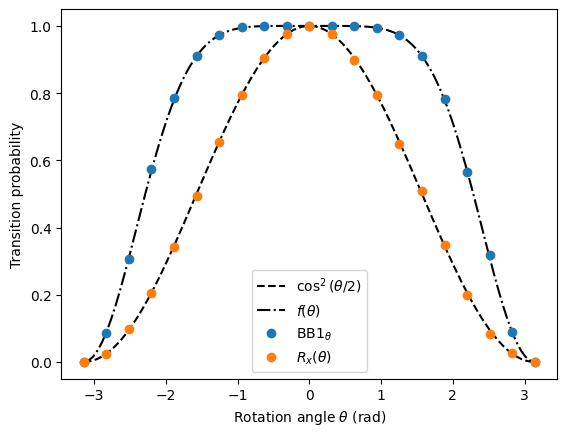

In [31]:
theta = np.linspace(-np.pi, np.pi, 100)
theory1 = np.cos(theta/2) ** 2 
plt.plot(theta, theory1, 'k--', label=r'$\cos^2(\theta/2)$')

theory2 = (1/8) * np.cos(theta/2) ** 2 * (3 * np.cos(theta/2) ** 8 - 15 * np.cos(theta/2) ** 6 
                                         + 35 * np.cos(theta/2) ** 4 - 45 * np.cos(theta/2) ** 2 + 30)
plt.plot(theta, theory2, 'k-.', label=r'$f(\theta)$')

plt.plot(thetas, qsp_p0s, 'o', label=r'BB1$_\theta$')
plt.plot(thetas, rx_p0s, 'o', label=r'$R_x(\theta)$')

plt.ylabel(r'Transition probability')
plt.xlabel(r'Rotation angle $\theta$ (rad)')

plt.legend()

plt.show()

Data points are from the simulation while the curves are from the theoretical curves given in [2]. There are a lot of things we can get from this. First off, to understand this, the transition probability is the probability we stay in the |0> state, starting from the |0> state. So a $\theta = 0$ means we don't do anything to the state at all and so we would expect to be in the |0> state 100% time as we see in the plots here. This makes sense when looking at the Rx curve as the probability drops to 0 when $\theta = \pi$ as that means we applied a $R_x(\pi)$ pulse. 

We see that results agree with the figure from [2] and the theoretical curve given by

\begin{equation}
    f(\theta) = \frac{1}{8} \cos^2\frac{\theta}{2} ( 3 \cos^8\frac{\theta}{2} - 15 \cos^6\frac{\theta}{2} + 35 \cos^4\frac{\theta}{2} - 45 \cos^2\frac{\theta}{2} + 30)
\end{equation}

which is also given in [2]. 

We also see that we have a broader band for the BB1 pulse sequence than the Rx single pulse. This means for the BB1 pulse sequence, there is a larger range of $\theta$ for which the qubit will be unflipped. This is a good thing if we want to be insensitive to noise for certain angles. This is why the BB1 is called BB (broadband) in QSP.  Then at around $\theta = 2 \pi /3 $, there is a large drop in the transition probablity. Comparing the slopes after this angle between BB1 and the single $R_x$ pulse, the BB1 curve has a higher slope which means we will be more sensitive to $\theta$ at certain angles! So the BB pulse has 2 advantages in the QSP scheme! 

### IonQ simulator

We now seek to implement the QSP BB1 sequence with the native gate set to see what happens if errors are introduced. We also want to see what would happen with quantum hardware. 

In [32]:
def qsp_bb1_native(theta):
    
    circ = QuantumCircuit(1)
    
    eta = np.arccos(-1/4) / 2
    phi = [np.pi/2, -eta, 2*eta, 0, -2*eta, eta]

    # 5
    delay = -2*phi[5]/(2*np.pi)
    # R_x(theta)
    # The RZ phase shift is incorporated by the delay term
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    circ.barrier()
    
    # 4
    # The new delay increases by the new phi and theta from previous gates
    delay += -2*phi[4]/(2*np.pi) + theta
    # R_x(theta)
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    circ.barrier()
    
    # 3
    delay += -2*phi[3]/(2*np.pi) + theta
    # R_x(theta)
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    circ.barrier()
    
    # 2
    delay += -2*phi[2]/(2*np.pi) + theta
    # R_x(theta)
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    circ.barrier()
    
    # 1
    delay += -2*phi[1]/(2*np.pi) + theta
    # R_x(theta)
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    # 0
    # circ.rz(phi=-2*phi[0], qubit=0)
    # We're supposed to have an Rz here but since it does not affect
    # the probabilities we just ignore it since we cannot implement it
    # using the IonQ system's current toolset.
    
    circ.measure_all()

    return circ

def Rx_circ_native(theta):
    circ = QuantumCircuit(1)

    # R_x(theta)
    circ.append(GPI2Gate(-0.25),[0]) 
    circ.append(GPI2Gate(0.25 + theta),[0]) 
    
    # Measure the qubit
    circ.measure_all()
    
    return circ


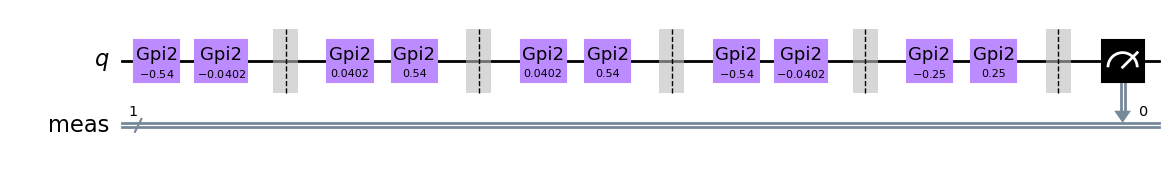

In [33]:
qsp_bb1_native(0).draw('mpl')

In [34]:
# Need to modify to fractional rotations from radians for the native set
thetas = np.linspace(-0.5, 0.5, 11)

qsp_circuits = []
rx_circuits = []

for theta in thetas:
    qsp_circuits.append( qsp_bb1_native(theta) )
    rx_circuits.append( Rx_circ_native(theta) )

In [35]:
qsp_p0s = []
for circuit in qsp_circuits:
    job = sim_backend_nat.run(circuit, shots=1000)
    qsp_p0s.append( calc_p0(job.result().get_counts()) )

...................................................................................

In [36]:
rx_p0s = []
for circuit in rx_circuits:
    job = sim_backend_nat.run(circuit, shots=1000)
    rx_p0s.append( calc_p0(job.result().get_counts()) )

..............................................................................

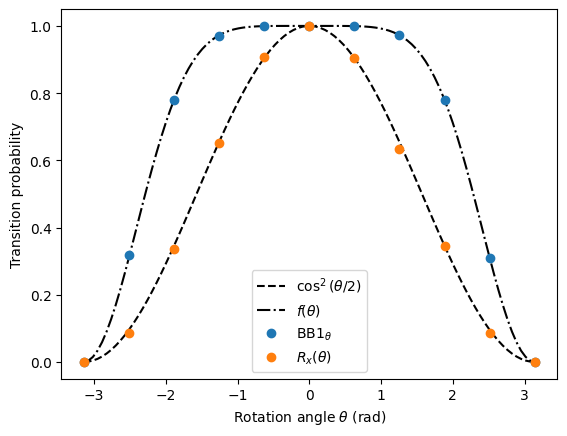

In [37]:
theta = np.linspace(-np.pi, np.pi, 100)
theory1 = np.cos(theta/2) ** 2 
plt.plot(theta, theory1, 'k--', label=r'$\cos^2(\theta/2)$')

theory2 = (1/8) * np.cos(theta/2) ** 2 * (3 * np.cos(theta/2) ** 8 - 15 * np.cos(theta/2) ** 6 
                                         + 35 * np.cos(theta/2) ** 4 - 45 * np.cos(theta/2) ** 2 + 30)
plt.plot(theta, theory2, 'k-.', label=r'$f(\theta)$')


plt.plot(2*np.pi*thetas, qsp_p0s, 'o', label=r'BB1$_\theta$')
plt.plot(2*np.pi*thetas, rx_p0s, 'o', label=r'$R_x(\theta)$')

plt.ylabel(r'Transition probability')
plt.xlabel(r'Rotation angle $\theta$ (rad)')

plt.legend()

plt.show()

Comparing the cloud simulator to the ionq simulator, we see that the data points align pretty similarly in both cases. They follow the theoretical curves which is expected. 

### IonQ QPU

Now we run the same code on the IonQ QPU.

In [38]:
qsp_jobs = []
print('Running jobs for the QSP circuits...')
for circuit in qsp_circuits:
    job = qpu_backend_nat.run(circuit, shots=1000)
    print('Job ID:', job.job_id())


Running jobs for the QSP circuits...
Job ID: 1ce2855c-9a9f-11ed-81ee-acde48001122
Job ID: 1de0ac72-9a9f-11ed-81ee-acde48001122
Job ID: 1e44a524-9a9f-11ed-81ee-acde48001122
Job ID: 1eb0bbd8-9a9f-11ed-81ee-acde48001122
Job ID: 1f1fc5dc-9a9f-11ed-81ee-acde48001122
Job ID: 1f84a010-9a9f-11ed-81ee-acde48001122
Job ID: 1fe8928c-9a9f-11ed-81ee-acde48001122
Job ID: 204cd972-9a9f-11ed-81ee-acde48001122
Job ID: 20b1df02-9a9f-11ed-81ee-acde48001122
Job ID: 21134daa-9a9f-11ed-81ee-acde48001122
Job ID: 2174b266-9a9f-11ed-81ee-acde48001122


Copying the Job IDs below for reference cause it might take a while:
    Job ID: 1ce2855c-9a9f-11ed-81ee-acde48001122
    Job ID: 1de0ac72-9a9f-11ed-81ee-acde48001122
    Job ID: 1e44a524-9a9f-11ed-81ee-acde48001122
    Job ID: 1eb0bbd8-9a9f-11ed-81ee-acde48001122
    Job ID: 1f1fc5dc-9a9f-11ed-81ee-acde48001122
    Job ID: 1f84a010-9a9f-11ed-81ee-acde48001122
    Job ID: 1fe8928c-9a9f-11ed-81ee-acde48001122
    Job ID: 204cd972-9a9f-11ed-81ee-acde48001122
    Job ID: 20b1df02-9a9f-11ed-81ee-acde48001122
    Job ID: 21134daa-9a9f-11ed-81ee-acde48001122
    Job ID: 2174b266-9a9f-11ed-81ee-acde48001122


In [40]:
qsp_jobs_retrieved = [qpu_backend_nat.retrieve_job('1ce2855c-9a9f-11ed-81ee-acde48001122'),
                      qpu_backend_nat.retrieve_job('1de0ac72-9a9f-11ed-81ee-acde48001122'),
                      qpu_backend_nat.retrieve_job('1e44a524-9a9f-11ed-81ee-acde48001122'),
                      qpu_backend_nat.retrieve_job('1eb0bbd8-9a9f-11ed-81ee-acde48001122'),
                      qpu_backend_nat.retrieve_job('1f1fc5dc-9a9f-11ed-81ee-acde48001122'),
                      qpu_backend_nat.retrieve_job('1f84a010-9a9f-11ed-81ee-acde48001122'),
                      qpu_backend_nat.retrieve_job('1fe8928c-9a9f-11ed-81ee-acde48001122'),
                      qpu_backend_nat.retrieve_job('204cd972-9a9f-11ed-81ee-acde48001122'),
                      qpu_backend_nat.retrieve_job('20b1df02-9a9f-11ed-81ee-acde48001122'),
                      qpu_backend_nat.retrieve_job('21134daa-9a9f-11ed-81ee-acde48001122'),
                      qpu_backend_nat.retrieve_job('2174b266-9a9f-11ed-81ee-acde48001122')
                     ] 

print('QSP Jobs are done?')
for job in qsp_jobs_retrieved:
    print(job.done())

QSP Jobs are done?
False
False
False
False
False
False
False
False
False
False
False


In [41]:
rx_jobs = []
print('Running jobs for the Rx circuits...')
for circuit in rx_circuits:
    job = qpu_backend_nat.run(circuit, shots=1000)
    print('Job ID:', job.job_id())

Running jobs for the Rx circuits...
Job ID: b7f112a2-9a9f-11ed-81ee-acde48001122
Job ID: b88c38ae-9a9f-11ed-81ee-acde48001122
Job ID: b9097b66-9a9f-11ed-81ee-acde48001122
Job ID: b97de122-9a9f-11ed-81ee-acde48001122
Job ID: b9f1dd16-9a9f-11ed-81ee-acde48001122
Job ID: ba53e718-9a9f-11ed-81ee-acde48001122
Job ID: bab8e672-9a9f-11ed-81ee-acde48001122
Job ID: bb2f45ba-9a9f-11ed-81ee-acde48001122
Job ID: bb9a6b9c-9a9f-11ed-81ee-acde48001122
Job ID: bbffb272-9a9f-11ed-81ee-acde48001122
Job ID: bc6a28b4-9a9f-11ed-81ee-acde48001122


Rx Job IDs:
Job ID: b7f112a2-9a9f-11ed-81ee-acde48001122
Job ID: b88c38ae-9a9f-11ed-81ee-acde48001122
Job ID: b9097b66-9a9f-11ed-81ee-acde48001122
Job ID: b97de122-9a9f-11ed-81ee-acde48001122
Job ID: b9f1dd16-9a9f-11ed-81ee-acde48001122
Job ID: ba53e718-9a9f-11ed-81ee-acde48001122
Job ID: bab8e672-9a9f-11ed-81ee-acde48001122
Job ID: bb2f45ba-9a9f-11ed-81ee-acde48001122
Job ID: bb9a6b9c-9a9f-11ed-81ee-acde48001122
Job ID: bbffb272-9a9f-11ed-81ee-acde48001122
Job ID: bc6a28b4-9a9f-11ed-81ee-acde48001122

In [42]:
rx_jobs_retrieved = [qpu_backend_nat.retrieve_job('b7f112a2-9a9f-11ed-81ee-acde48001122'),
                     qpu_backend_nat.retrieve_job('b88c38ae-9a9f-11ed-81ee-acde48001122'),
                     qpu_backend_nat.retrieve_job('b9097b66-9a9f-11ed-81ee-acde48001122'),
                     qpu_backend_nat.retrieve_job('b97de122-9a9f-11ed-81ee-acde48001122'),
                     qpu_backend_nat.retrieve_job('b9f1dd16-9a9f-11ed-81ee-acde48001122'),
                     qpu_backend_nat.retrieve_job('ba53e718-9a9f-11ed-81ee-acde48001122'),
                     qpu_backend_nat.retrieve_job('bab8e672-9a9f-11ed-81ee-acde48001122'),
                     qpu_backend_nat.retrieve_job('bb2f45ba-9a9f-11ed-81ee-acde48001122'),
                     qpu_backend_nat.retrieve_job('bb9a6b9c-9a9f-11ed-81ee-acde48001122'),
                     qpu_backend_nat.retrieve_job('bbffb272-9a9f-11ed-81ee-acde48001122'),
                     qpu_backend_nat.retrieve_job('bc6a28b4-9a9f-11ed-81ee-acde48001122')
                    ] 

print('Rx Jobs are done?')
for job in rx_jobs_retrieved:
    print(job.done())

Rx Jobs are done?
False
False
False
False
False
False
False
False
False
False
False


In [9]:
qsp_p0s = []
for job in qsp_jobs_retrieved:
    print(job.result().get_counts())
    qsp_p0s.append( calc_p0(job.result().get_counts()) )

{'0': 151, '1': 9849}
{'0': 3034, '1': 6966}
{'0': 7810, '1': 2190}
{'0': 9691, '1': 309}
{'0': 9971, '1': 29}
{'0': 15988}
{'0': 9929, '1': 71}
{'0': 9216, '1': 784}
{'0': 7018, '1': 2982}
{'0': 2694, '1': 7306}
{'0': 86, '1': 9914}


In [10]:
rx_p0s = []
for job in rx_jobs_retrieved:
    print(job.result().get_counts())
    rx_p0s.append( calc_p0(job.result().get_counts()) )

{'0': 46, '1': 9954}
{'0': 976, '1': 9024}
{'0': 3437, '1': 6563}
{'0': 6506, '1': 3494}
{'0': 8994, '1': 1006}
{'0': 14992}
{'0': 9076, '1': 924}
{'0': 6656, '1': 3344}
{'0': 3538, '1': 6462}
{'0': 1075, '1': 8925}
{'0': 50, '1': 9950}


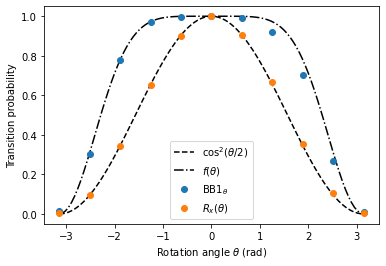

In [13]:
theta = np.linspace(-np.pi, np.pi, 100)
theory1 = np.cos(theta/2) ** 2 
plt.plot(theta, theory1, 'k--', label=r'$\cos^2(\theta/2)$')

theory2 = (1/8) * np.cos(theta/2) ** 2 * (3 * np.cos(theta/2) ** 8 - 15 * np.cos(theta/2) ** 6 
                                         + 35 * np.cos(theta/2) ** 4 - 45 * np.cos(theta/2) ** 2 + 30)
plt.plot(theta, theory2, 'k-.', label=r'$f(\theta)$')


plt.plot(2*np.pi*thetas, qsp_p0s, 'o', label=r'BB1$_\theta$')
plt.plot(2*np.pi*thetas, rx_p0s, 'o', label=r'$R_x(\theta)$')

plt.ylabel(r'Transition probability')
plt.xlabel(r'Rotation angle $\theta$ (rad)')

plt.legend()

plt.show()

Looking at the plots, we see that for the BB1 implementation, the data points are a bit off from the theoretical plot and from the simulations which means there is some error associated with native gates in the ionq computer hardware that isn't accounted for in the pulses. It will be interesting to see what is exactly causing this error but due to time constraints, we will put an end to this investigation for now.